# Log-Normal model integration test

Try Log-Normal Model inference on data generated from that model. Should recover synthetic data.

This is the version of the model with between-unit covariance.

## If you want overdispersion in the model:

Set the following to `True`:

In [1]:
overdisp = True

# Generate Test Data

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import lognormal as ln
from fbi import fb_infer
from helpers import *
from autograd import grad
%matplotlib inline
sns.set_style('darkgrid')

np.random.seed(11739)

/home/pearson/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/home/pearson/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Define model parameters

In [3]:
U = 100  # units
T = 1000  # time points/frames
Kdata = 3  # number of latent states
dt = 1/30  # seconds per frame

## Generate Markov chains

In [4]:
# make transition matrix
A = np.array([[0.98, 0.05], [0.02, 0.95]])

In [5]:
chain = np.empty((T, Kdata))

chain[0, :] = 0  # start all categories "off"
for t in xrange(1, T):
    for k in xrange(Kdata):
        chain[t, k] = stats.bernoulli.rvs(A[1, chain[t - 1, k]])

/home/pearson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


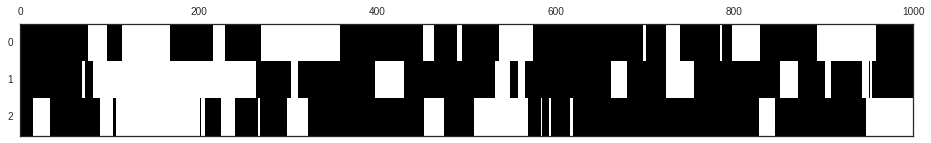

In [6]:
matshow(chain.T);

## Baseline distributions

Scipy parameterizes the log-normal as
$$
\text{log-}\mathcal{N}(x) = \frac{1}{x\sqrt{2\pi \sigma^2}} \exp\left({-\frac{(\log (x/x_0))^2}{2\sigma^2}}\right)
$$ 
from which we can see that $\log x$ is normally distributed with mean $\mu = \log x_0$ and variance $\sigma^2$.

In scipy, $x_0$ is the scale parameter and $\sigma$ is the shape.

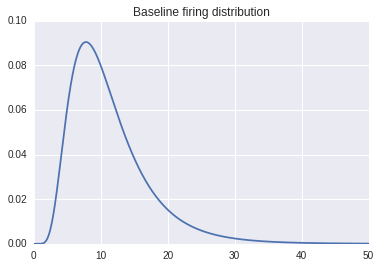

In [7]:
bl_scale = 10
bl_mean = np.log(bl_scale)
bl_sig = 0.5
# baselines should follow a different distribution
bl = stats.norm.rvs(scale=bl_sig, loc=bl_mean, size=U) 

xx = np.linspace(0, 50, 1000)
plt.plot(xx, stats.lognorm.pdf(xx, scale=bl_scale, s=bl_sig))
plt.title('Baseline firing distribution');

## Firing rate effect distributions

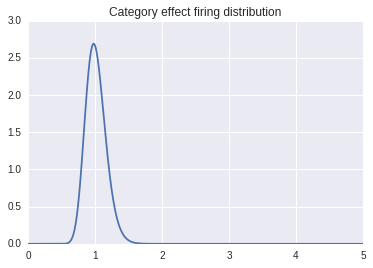

In [8]:
fr_sig = 0.15
fr_scale = 1.
fr_mean = np.log(fr_scale)
lam = stats.norm.rvs(loc=fr_mean, scale=fr_sig, size=(Kdata, U))

xx = np.linspace(0, 5, 1000)
plt.plot(xx, stats.lognorm.pdf(xx, scale=fr_scale, s=fr_sig))
plt.title('Category effect firing distribution');

## Overdispersion

We want a covariance matrix $\Sigma_\varepsilon$ that captures (weak) correlations among units. To do this, we construct a correlation matrix $S_\varepsilon$ and then scale each coordinate by $\tau$:

$$
\Sigma_\varepsilon = S \odot (\tau * \tau^\top)
$$

[ 0.29942463  0.65994481  0.26519165  0.79168222  0.419829    0.1826943
  0.28902472  0.13011582  0.74753111  0.16193749  0.68544654  0.56588242
  0.80041538  0.49421282  0.69117984  0.43155304  0.0587574   0.49847858
  0.02067152  0.62067592  0.35893653  0.63986924  0.22642793  0.55461156
  0.63934104  0.425174    0.78337394  0.53046781  0.31051128  0.79775842
  0.40083336  0.13715577  0.09873229  0.10357271  0.134854    0.44477413
  0.69627114  0.1931029   0.13915312  0.12780365  0.35023895  0.17644728
  0.63341372  0.49462841  0.57368459  0.42562846  0.63391571  0.0550737
  0.08383888  0.73264397  0.29833101  0.05897002  0.8067521   0.52138807
  0.63638191  0.82992572  0.61571685  0.44777484  0.32895911  0.82260787
  0.21663114  0.8130631   0.07957455  0.64161387  0.75623049  0.51479962
  0.01473497  0.55378116  0.31259829  0.43609215  0.36495791  0.84665298
  0.58680451  0.49019794  0.03224053  0.26271002  0.47260068  0.18716322
  0.64936387  0.13394556  0.00591627  0.07750265  0.0

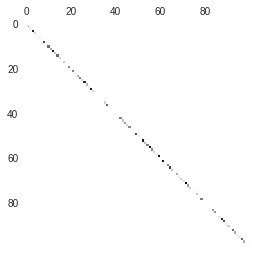

In [9]:
def gencov(U, noise_scale):
    tau = noise_scale * np.random.rand(U)
    S = np.eye(U)
    eps = 0.05
    S += np.diag(eps * np.ones(U - 1), 1)
    S += np.diag(eps * np.ones(U - 1), -1)
    Sig = S * np.outer(tau, tau)
    return tau, Sig
if overdisp:
    noise_scale = 0.85
    tau, Sig = gencov(U, noise_scale)

    print(tau)
    print(Sig)
    plt.matshow(Sig);

## External regressors

In [10]:
# just as above, make a set of Markov-esque regressors

# number of regressors
R = 3  

# "transition matrix" -- want regressors to have some temporal coherence
AX = np.array([[0.98, 0.05], [0.02, 0.95]])

In [11]:
Xchain = np.empty((T, R))

Xchain[0, :] = 0  # start second category off
for t in xrange(1, T):
    for k in xrange(0, R):
        Xchain[t, k] = stats.bernoulli.rvs(AX[1, Xchain[t - 1, k]])

/home/pearson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


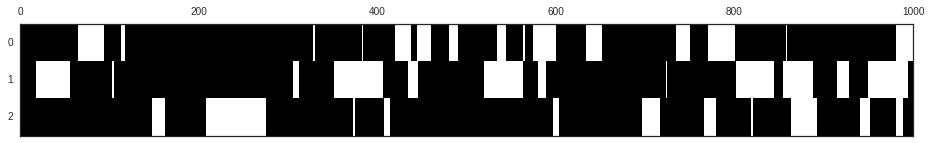

In [12]:
matshow(Xchain.T)

In [13]:
Xf = pd.DataFrame(Xchain, columns=map(lambda x: 'X' + str(x), xrange(R)))
Xf.index.name = 'frame'
Xf = Xf.reset_index()

In [14]:
Xf.head()

,frame,X0,X1,X2
0,0,0.0,0.0,0.0
1,1,0.0,0.0,0.0
2,2,0.0,0.0,0.0
3,3,0.0,0.0,0.0
4,4,0.0,0.0,0.0


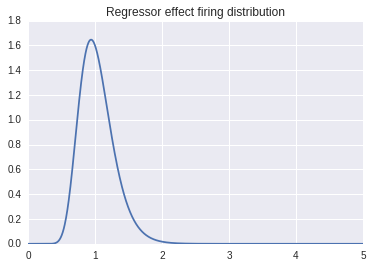

In [15]:
Xfr_scale = 1
Xfr_mean = np.log(Xfr_scale)
Xfr_sig = 0.25
Xlam = stats.norm.rvs(loc=Xfr_mean, scale=Xfr_sig, size=(R, U))

xx = np.linspace(0, 5, 1000)
plt.plot(xx, stats.lognorm.pdf(xx, s=Xfr_sig, scale=Xfr_scale))
plt.title('Regressor effect firing distribution');

## Calculate firing rates

Let $\lambda_0$ be the baseline effect, $b_k$ the firing rate effect for latent category $k$ with binary indicator $z_{tk}$ at time $t$, and $\beta_r$ the firing rate effect for external regressor $r$ with value $x_{tr}$ at time $t$. Finally, let $\epsilon_t$ be the overdispersion random effect. Then
$$
\eta_{tu} = \log f_{tu} = \lambda_{0u} + \sum_k z_{tk} b_{ku} + \sum_r x_{tr} \beta_{ru} + \epsilon_t \\
\mathrm{cov}[\epsilon_t] = \Sigma_\varepsilon
$$

In [16]:
# add overdispersion
if overdisp:
    eps = stats.multivariate_normal.rvs(mean=None, cov=Sig, size=(T,))
else:
    eps = 0
    
# calculate firing rate
fr = np.exp(bl + chain.dot(lam) + Xchain.dot(Xlam) + eps) * dt


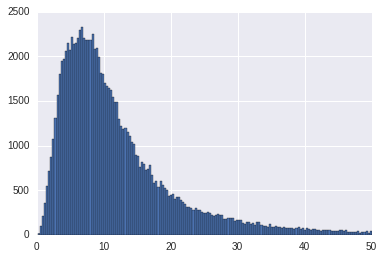

In [17]:
# get a crude sense of population firing
plt.hist(fr.ravel() / dt, bins=1000);
plt.xlim(0, 50);

## Look at generated data

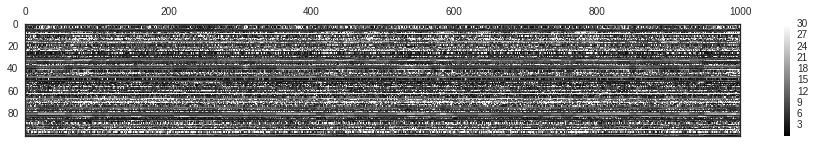

In [18]:
matshow(fr.T / dt, vmax=30);
plt.colorbar();

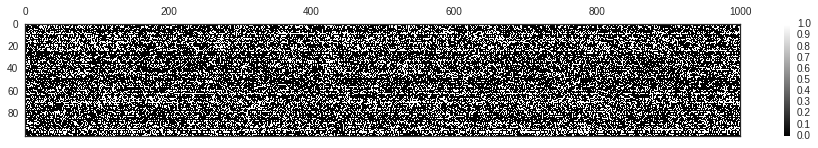

In [19]:
# draw from Poisson
N = stats.poisson.rvs(fr)
matshow(N.T, vmax=1);
plt.colorbar();

In [20]:
# make count frame
df = pd.DataFrame(N)
df.index.name = 'frame'
df = df.reset_index()
df = pd.melt(df, id_vars='frame')
df.columns = ['frame', 'unit', 'count']
df['movie'] = 1

df = df.merge(Xf)

df.head()

,frame,unit,count,movie,X0,X1,X2
0,0,0,0,1,0.0,0.0,0.0
1,0,1,0,1,0.0,0.0,0.0
2,0,2,0,1,0.0,0.0,0.0
3,0,3,0,1,0.0,0.0,0.0
4,0,4,0,1,0.0,0.0,0.0


Finally, convert (frame, movie) pairs to unique times:

In [21]:
df = frames_to_times(df)
M = df.shape[0]
df.head()

,unit,count,X0,X1,X2,time
0,0,0,0.0,0.0,0.0,0
1,1,0,0.0,0.0,0.0,0
2,2,0,0.0,0.0,0.0,0
3,3,0,0.0,0.0,0.0,0
4,4,0,0.0,0.0,0.0,0


# Testing

Just testing out sanity on $\mathcal{L}$.

## Spikes and $\eta$ term

In [22]:
eta_mean = stats.norm.rvs(scale=bl_sig, loc=bl_mean, size=(T, U)) 
eta_cov = np.random.rand(T, U, U)

print(ln.log_observed_spikes(N, eta_mean, eta_cov))

-1370501.38425


## Normal $\mathbb{E}[\log p]$ and entropy

In [23]:
m_a = 0.1  # mean of prior on a
s_a = 0.05**2  # variance of prior on a
mu_a = 0.05 * np.random.randn(U)
sig_a = 0.1 * np.random.rand(U)

print(ln.expected_log_normal(m_a, s_a, mu_a, sig_a))
print(ln.normal_entropy(mu_a, sig_a))

-1282.82522634
-61.7882305949


In [24]:
m_b = 0.1 * np.ones((R,))
S_b = 0.05**2 * np.eye(R)
mu_b = 0.05 * np.random.randn(U, R)
Sig_b = 0.05**2 * np.random.rand(U, R, R)

print(ln.expected_log_mvnormal(m_b, S_b, mu_b, Sig_b))
print(ln.mvnormal_entropy(mu_b, Sig_b))

-779.789502863
-709.706090114


## HMM state sequence and entropy

In [25]:
psi = np.random.rand(T, 1)
log_psi = np.hstack([np.log(psi), 1 - np.log(psi)])
log_A = np.log(A)
log_pi = np.log([0.9, 0.1])
xi, logZ, Xi = fb_infer(A, np.exp(log_pi), np.exp(psi))

print(ln.hmm_entropy(log_psi, log_A, log_pi, xi, Xi, logZ))
print(ln.expected_log_state_sequence(xi, Xi, log_A, log_pi))

781.288444431
-126.678346083


In [26]:
np.tile(xi, (1, 1, 6)).shape

(1, 1000, 12)

## Emission probabilities for Markov Chain

In [27]:
Kthis = 4
tau = np.random.rand(U)
mu_c = np.random.randn(U, Kthis)
Sig_c = np.random.rand(U, Kthis, Kthis)
xi_this = np.stack([xi] * Kthis, 2)
print(ln.log_emission_probs(tau, eta_mean, mu_a, mu_b, Xchain, mu_c, Sig_c, xi_this).shape)

(1000, 2, 4)


## Entropies and log priors for $A$ and $\pi$

In [28]:
print(ln.dirichlet_entropy(A.T))
print(ln.expected_log_dirichlet(A.T, A.T))

-60.985228435
60.985228435


## Inverse-Gamma for variances:

In [29]:
alpha = 5 * np.random.rand(T, U)
beta = 2 * np.random.rand(T, U)
aa = 3.7 * np.random.rand(T, U)
bb = 5.6 * np.random.rand(T, U)

print(ln.inverse_gamma_entropy(alpha, beta))
print(ln.expected_log_inverse_gamma(aa, bb, alpha, beta))

270343.390029
-929713.117283


## LKJ covariances:

In [30]:
eta = 10
h = 15
print(ln.expected_log_LKJ(h, eta, U))
print(ln.LKJ_entropy(eta, U))

7337.92328772
-7359.66050036


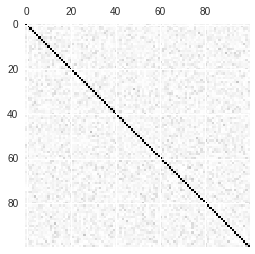

In [31]:
Omega = ln.draw_LKJ(1, U)
plt.matshow(np.abs(Omega))

In [32]:
betas = ln.LKJ_to_beta_pars(1, U)
print(betas)
cpc = 2 * np.random.beta(betas, betas) - 1
print(cpc)
corrvec = ln.corr_from_cpc(cpc)
print(corrvec)

[ 50.5  50.5  50.5 ...,   2.    2.    1.5]
[ 0.05059452  0.01430549 -0.00864461 ...,  0.52723698  0.02792851
  0.63052371]
[ 0.05059452  0.01430549 -0.00864461 ..., -0.07011951  0.05455714
 -0.03907916]


(-1, 1)

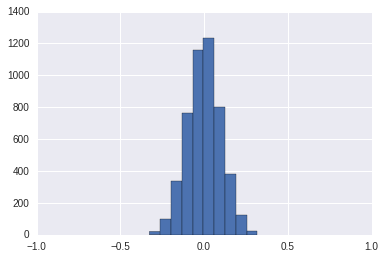

In [33]:
plt.hist(corrvec);
plt.xlim(-1, 1)

# Set up Priors

## Priors on baseline:

We will use a simple model for baseline priors
$$
a_u \sim \mathcal{N}(m_a, s_a^2)
$$
where the actual baseline firing rate is $f = e^{a}$.

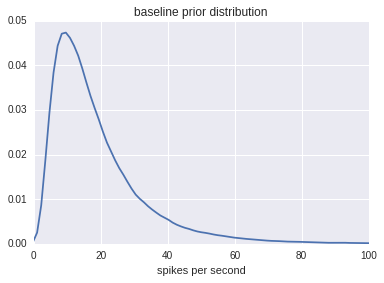

In [34]:
m_a = np.log(15) + np.log(dt)
s_a = 0.7

xx = np.linspace(0, 50, 1000)
samples = np.exp(stats.norm.rvs(loc=m_a, scale=s_a, size=1e5))
sns.kdeplot(samples / dt, clip=(0, 150))
plt.title('baseline prior distribution')
plt.xlim(0, 100);
plt.xlabel('spikes per second');

## Priors on latent firing rate effects:

Here, we adopt a prior
$$
c_{\cdot u} \sim \mathcal{N}(0, S_{c}) \\
$$

In [35]:
# set number of categories to fit
K = 5

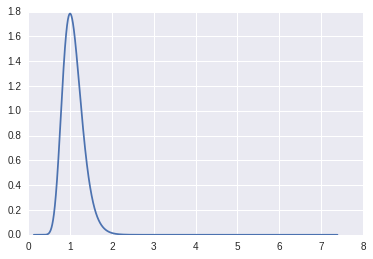

In [36]:
m_c = 0  # prior mean
s_c = 0.05  # std
tau_b = 1/s_c**2
S_c = tau_b * np.eye(K)  # prior cov

xx = np.linspace(-2, 2, 5000)
plt.plot(np.exp(xx), stats.norm.pdf(xx, scale=np.sqrt(s_c)))

## Priors on regression coefficients:

Similar to firing rate effects:

$$
b_{\cdot u} \sim \mathcal{N}(0, S_{b}) \\
$$

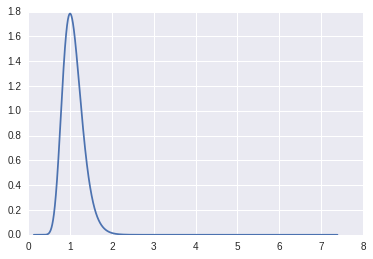

In [37]:
m_b = 0  # prior mean
s_b = 0.05  # std
S_b = s_b * np.eye(R)  # prior cov

xx = np.linspace(-2, 2, 5000)
plt.plot(np.exp(xx), stats.norm.pdf(xx, scale=np.sqrt(s_b)))

## Priors on $A$, $\pi$

In [38]:
###### A ###############
A_off = 10.
A_on = 1.
Avec = np.r_[A_off, A_on].reshape(2, 1, 1)
A_prior = np.tile(Avec, (1, 2, K))

###### pi ###############
pi_off = 15.
pi_on = 1.
pi_prior = np.tile(np.r_[pi_off, pi_on].reshape(2, 1), (1, K))

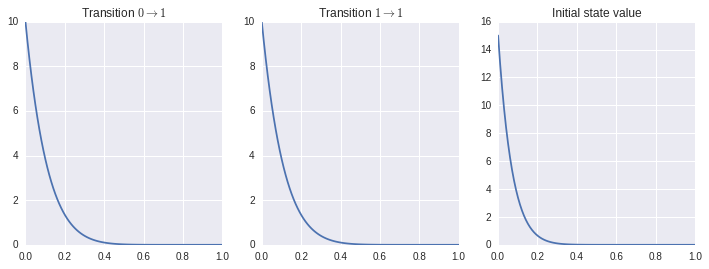

In [39]:
xx = np.linspace(0, 1, 100)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(xx, stats.beta.pdf(xx, A_prior[1, 0, 0], A_prior[0, 0, 0]))
plt.title(r'Transition $0 \rightarrow 1$');

plt.subplot(1, 3, 2)
plt.plot(xx, stats.beta.pdf(xx, A_prior[1, 1, 0], A_prior[0, 1, 0]))
plt.title(r'Transition $1 \rightarrow 1$');

plt.subplot(1, 3, 3)
plt.plot(xx, stats.beta.pdf(xx, pi_prior[1, 0], pi_prior[0, 0]))
plt.title('Initial state value');


## Priors on $\Sigma_\varepsilon$ (overdispersion)

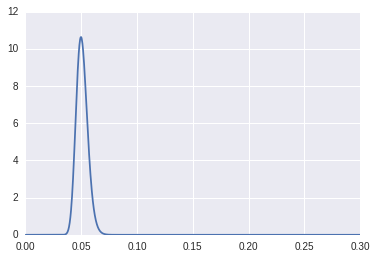

In [40]:
h_eps = 1
eta = 1
a_eps, b_eps = 200, 10
s_eps = stats.invgamma.rvs(a_eps, scale=b_eps)
sig_eps = 0.05 * np.ones(U)  # post var for noise scale
m_eps = a_eps/b_eps
v_eps = a_eps/b_eps**2

xx = np.linspace(0, 0.3, 1000)
plt.plot(xx, np.sqrt(stats.invgamma.pdf(xx, a_eps, scale=b_eps)))

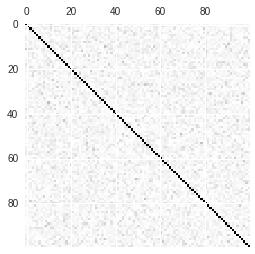

In [41]:
Sig_eps = ln.draw_LKJ(h_eps, U)
    
plt.matshow(np.abs(Sig_eps))

# Initial guesses for posterior parameters

In [42]:
# baseline posteriors
mu_a = (np.log(15) + np.log(dt)) * np.random.randn(U)
sig_a = 0.06 * np.ones(U)
log_sig_a = np.log(sig_a)

In [43]:
# firing rate effects for regressors
mu_b = 0.1 * np.random.randn(U, R)
Sig_b = 0.05 * np.tile(np.eye(R).reshape(1, R, R), (U, 1, 1))
Sig_b_chol = np.linalg.cholesky(Sig_b)

In [44]:
# firing rate effects for latents
mu_c = 0.1 * np.random.randn(U, K)
Sig_c = 0.05 * np.tile(np.eye(K).reshape(1, K, K), (U, 1, 1))
Sig_c_chol = np.linalg.cholesky(Sig_c)

In [45]:
log_A = np.log(np.tile(np.array([0.9, 0.1]).reshape(2, 1, 1), (1, 2, K)))
log_pi = np.log(np.tile(np.array([0.9, 0.1]).reshape(2, 1), (1, K)))
A_post = np.exp(log_A)
pi_post = np.exp(log_pi)

pp = np.random.rand(T)
psi = np.stack([pp, 1 - pp], axis=1)
log_psi = np.log(psi)

xi01 = np.random.rand(T, K)
xi0 = np.empty((T, 2, K))
xi0[:, 0, :] = 1 - xi01
xi0[:, 1, :] = xi01

In [94]:
# overdispersion
alpha_eps, beta_eps = 10 * np.ones(U), np.ones(U)
log_alpha_eps = np.log(alpha_eps)
log_beta_eps = np.log(beta_eps)
log_mu_eps = np.log(10 * np.ones(U))
log_ups_eps = np.log(0.02 * np.ones(U))

eta_eps = 2.1
log_eta_eps = np.log(eta_eps - 1)

In [47]:
#etas
# eta_mean = mu_a + Xchain.dot(mu_b.T) + xi0[:, 1, :].dot(mu_c.T)
eta_mean = np.maximum(np.log(N), -2)
eta_scale = 0.01
eta_cov = eta_scale * np.tile(np.eye(U).reshape(1, U, U), (T, 1, 1))
eta_cov_chol = np.linalg.cholesky(eta_cov)

# Initialize $\eta$ and $\overline{\eta}$ by data

In [48]:
import statsmodels.api as sm

Xmat = np.concatenate([np.ones((T, 1)), Xchain, xi0[:, 1, :]], axis=1)

for u in range(U):
    m = sm.GLM(N[:, u], Xmat, family=sm.families.Poisson()).fit()
    mu_a[u] = m.params[0]
    mu_b[u, :] = m.params[1:R + 1]
    mu_c[u, :] = m.params[1:K + 1]
    eta_mean[:, u] = np.log(m.fittedvalues)

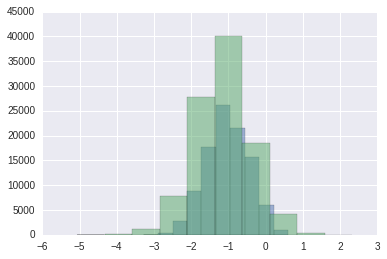

In [49]:
plt.hist(eta_mean.ravel(), alpha=0.5);
plt.hist(np.log(fr).ravel(), alpha=0.5);

## Check $\mathcal{L}$:

In [50]:
%%time
(eta_cov, sig_a, Sig_b, Sig_c, 
     A_post, pi_post, mu_eps, ups_eps, eta_eps) = ln.transform_inputs(
        eta_cov_chol, log_sig_a, Sig_b_chol, Sig_c_chol, 
        log_A, log_pi, log_mu_eps, log_ups_eps, log_eta_eps)
    
ln.L(N, Xchain, xi0, m_a, s_a, m_b, S_b, m_c, S_c, 
                      A_prior, pi_prior, h_eps, m_eps, v_eps, 
             eta_mean, eta_cov, mu_a, sig_a, mu_b, Sig_b, mu_c, Sig_c, 
                      A_post, pi_post, mu_eps, ups_eps, eta_eps)

CPU times: user 4.07 s, sys: 76 ms, total: 4.15 s
Wall time: 983 ms


## Check $\nabla \mathcal{L}$:

In [51]:
def Lflat(x, xi0):
    (eta_mean, eta_cov_chol, mu_a, log_sig_a, mu_b, Sig_b_chol, mu_c, Sig_c_chol, 
     log_A_post, log_pi_post, log_mu_eps, log_ups_eps, eta_eps) = ln.unpack(x, dimlist)
    
    # transform unconstrained to constrained params
    (eta_cov, sig_a, Sig_b, Sig_c, 
     A_post, pi_post, mu_eps, ups_eps, eta_eps) = ln.transform_inputs(
        eta_cov_chol, log_sig_a, Sig_b_chol, Sig_c_chol, 
        log_A_post, log_pi_post, log_mu_eps, log_ups_eps, log_eta_eps)
    
    L = ln.L(N, Xchain, xi0, m_a, s_a, m_b, S_b, m_c, S_c, 
                      A_prior, pi_prior, h_eps, m_eps, v_eps, 
             eta_mean, eta_cov, mu_a, sig_a, mu_b, Sig_b, mu_c, Sig_c, 
                      A_post, pi_post, mu_eps, ups_eps, eta_eps)
    return L

In [52]:
xx, dimlist = ln.pack(eta_mean, eta_cov_chol, 
                      mu_a, log_sig_a, 
                      mu_b, Sig_b_chol, 
                      mu_c, Sig_c_chol, 
                      log_A, log_pi, 
                      log_mu_eps, log_ups_eps, 
                      log_eta_eps)

In [53]:
xx.shape, dimlist

((10104631,),
 [(1000, 100),
  (1000, 100, 100),
  (100,),
  (100,),
  (100, 3),
  (100, 3, 3),
  (100, 5),
  (100, 5, 5),
  (2, 2, 5),
  (2, 5),
  (100,),
  (100,),
  ()])

In [54]:
gradL = grad(Lflat)

In [55]:
%%time
gg = gradL(xx, xi0)

CPU times: user 26.2 s, sys: 640 ms, total: 26.8 s
Wall time: 15.1 s


Take an initial small step to set very tetchy parameters ($\tau$) close to peak.

In [56]:
yy = xx + 1e-4 * gg

In [57]:
Lflat(yy, xi0)

-50504.702290453046

In [58]:
eps = 1e-4
nsteps = 20
nreps = 1
# yy = xx.copy()
print(Lflat(yy, xi0))
for k in range(nsteps):
    print("Iteration ", k)
    for ind in range(nreps):
        xi0[:] = ln.update_xi0(yy, xi0, Xchain, dimlist)
    gg = gradL(yy, xi0)
    yy += eps * gg
    print(Lflat(yy, xi0))

-50504.7022905
('Iteration ', 0)
-43998.9164518
('Iteration ', 1)
-39989.3374222
('Iteration ', 2)
-36875.5143616
('Iteration ', 3)
-34280.9180171
('Iteration ', 4)
-32007.746041
('Iteration ', 5)
-29943.195535
('Iteration ', 6)
-28021.1683635
('Iteration ', 7)
-26203.1070412
('Iteration ', 8)
-24465.644889
('Iteration ', 9)
-22793.2904295
('Iteration ', 10)
-21175.278211
('Iteration ', 11)
-19604.2054818
('Iteration ', 12)
-18075.1470676
('Iteration ', 13)
-16584.90304
('Iteration ', 14)
-15131.370155
('Iteration ', 15)
-13713.0816244
('Iteration ', 16)
-12328.914938
('Iteration ', 17)
-10977.9273614
('Iteration ', 18)
-9659.27111936
('Iteration ', 19)
-8372.15187021


In [58]:
pars = ln.unpack(yy, dimlist)

In [59]:
gradvec = ln.unpack(gg, dimlist)

In [98]:
idx = 6
gradvec[idx] * 1e-4 / pars[idx]

array([[  1.83001968e-06,  -1.67369632e-07,  -4.75151874e-07,
          4.82282032e-04,   1.95850731e-05],
       [ -1.18982680e-06,  -1.19505071e-07,   2.50614369e-07,
          5.80066930e-04,  -6.64235809e-07],
       [  1.80248984e-06,  -1.31211153e-07,  -6.44200062e-07,
         -2.49623912e-05,   8.40047613e-06],
       [  5.69440167e-07,  -9.08888286e-08,  -5.91971810e-07,
         -3.59063256e-05,   5.26536225e-06],
       [  7.22257741e-06,  -4.37561393e-07,  -1.03345914e-05,
         -6.27022714e-06,  -2.81261942e-06],
       [  2.11675031e-06,  -2.78828856e-06,   1.64301101e-06,
          2.35441984e-05,   2.69301487e-06],
       [ -8.32510165e-05,   1.44748635e-06,   2.98024000e-05,
          1.52347659e-05,   1.49924514e-05],
       [ -8.72112828e-07,   1.48887790e-07,  -1.46370204e-06,
         -1.82683575e-04,  -3.15846023e-06],
       [ -1.79541456e-06,  -6.25525430e-07,  -2.92077892e-06,
         -9.48924528e-05,   8.58715598e-05],
       [ -2.22383258e-06,  -4.1740002

In [92]:
gradvec[12]

array(0.0)

# Assess fit

## State coding

In [62]:
xi0[:] = ln.update_xi0(yy, xi0, Xchain, dimlist)

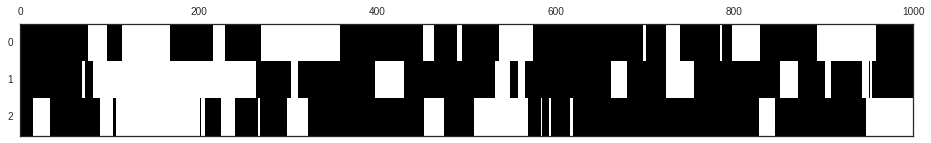

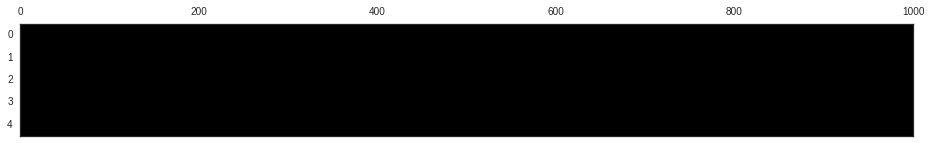

In [63]:
matshow(chain.T, vmin=0, vmax=1);
matshow(xi0[:, 1, :].T, vmin=0, vmax=1);

## Firing rate variables

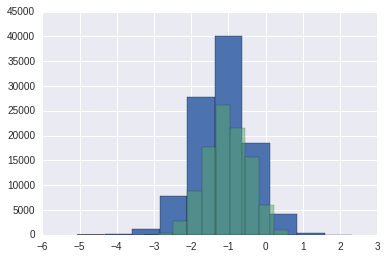

In [64]:
plt.hist(np.log(fr).ravel());
plt.hist(pars[0].ravel(), alpha=0.5);

## Baselines

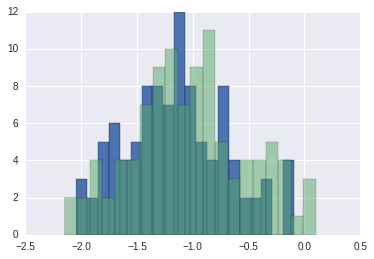

In [65]:
plt.hist(bl + np.log(dt), bins=20);
plt.hist(pars[2], bins=20, alpha=0.5);

## Regression coefficients

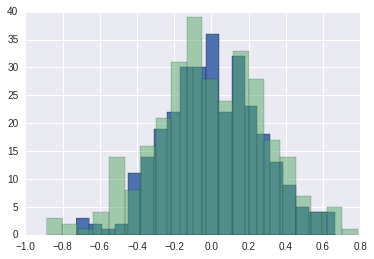

In [66]:
plt.hist(Xlam.ravel(), bins=20);
plt.hist(pars[4].ravel(), bins=20, alpha=0.5);

## HMM firing rate effects

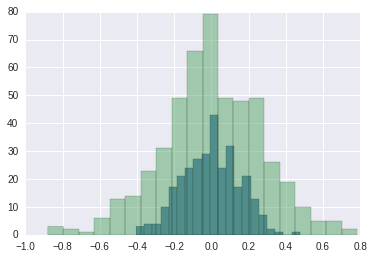

In [67]:
plt.hist(lam.ravel(), bins=20);
plt.hist(pars[6].ravel(), bins=20, alpha=0.5);

# Do inference with random restarts:

In [ ]:
numstarts = 1

In [ ]:
fitobjs = []
Lvals = []
for idx in xrange(numstarts):
    lnm = ln.LogNormalModel(df, K)
    lnm.initialize_baseline(**jitter_inits(baseline_dict, 0.25))
    lnm.initialize_fr_latents(**jitter_inits(fr_latent_dict, 0.25))
    lnm.initialize_latents(**jitter_inits(latent_dict, 0.05))
    lnm.initialize_fr_regressors(**jitter_inits(reg_dict, 0.05))
    if overdisp:
        lnm.initialize_overdispersion(**jitter_inits(od_dict, 0.25))
    lnm.finalize()
    
    print "Start {} -----------------------".format(idx)
    %time lnm.do_inference(tol=1e-4, verbosity=2)
    print "Final L = {}".format(lnm.L())
    Lvals.append(lnm.L())
    fitobjs.append(lnm)

In [ ]:
# pick out best fit
bestind = np.argmax(Lvals)
lnm = fitobjs[bestind]
del fitobjs  # to save memory

# Check results

## Do we correctly recover $z$?

Zoom in on a small part of the time series:

In [ ]:
Trng = (500, 1000)
matshow(chain.T[:, slice(*Trng)], vmin=0, vmax=1);
xi = lnm.nodes['HMM'].nodes['z'].z[1]
matshow(xi.T[:, slice(*Trng)], vmin=0, vmax=1);

What about the whole time series?

In [ ]:
matshow(chain.T, vmin=0, vmax=1);
matshow(xi.T, vmin=0, vmax=1);

In [ ]:
matshow(chain.T);
plt.title('Actual states')
matshow(xi.T, vmin=0, vmax=1);
plt.title('Inferred states')
matshow(fr.T / dt, vmax=30);
plt.title('Actual firing rate')
matshow(N.T, vmin=0, vmax=1);
plt.title('Spike rastergram');

In [ ]:
match = (chain.T.dot(xi) + (1 - chain.T).dot(1 - xi)) / T
mismatch = (chain.T.dot(1 - xi) + (1 - chain.T).dot(xi)) / T
overlap = np.maximum(match, mismatch)

## Calculate overlap between actual and inferred latents

Define the overlap as the maximum of the match or mismatch percentage. That is, if $x$ and $y$ are binary vectors, 
$$
\mathrm{overlap} = \max \{ \mathbb{E}[xy + (1-x)(1-y)], \mathbb{E}[(1-x)y + x(1-y)]\}
$$

In [ ]:
matshow(overlap, vmin=0, vmax=1)
plt.colorbar();
plt.xlabel('Inferred categories');
plt.ylabel('Actual categories');

In [ ]:
print overlap

## Diagnostics for gamma-distributed variables

Let's look at what we get for $\lambda$, $\theta$, and $\upsilon$:

### Baselines

In [ ]:
plt.figure(figsize=(12, 4))

actual_means = bl
inferred_means = lnm.nodes['baseline'].expected_x() - np.log(dt)

plt.subplot(1, 2, 1)
plt.hist(bl, bins=50, normed=True, alpha=0.25)
plt.hist(inferred_means, bins=50, normed=True, alpha=0.25);
plt.legend(['actual', 'inferred']);
plt.xlim([0, 5])
plt.title('Baseline firing rates');

plt.subplot(1, 2, 2)
plt.scatter(bl, inferred_means);
plt.xlabel('actual')
plt.ylabel('inferred')
plt.title('baseline rates');

### $\lambda$ terms (latents for each unit)

In [ ]:
var_shape = lnm.nodes['fr_latents_prec'].post_shape
var_rate = lnm.nodes['fr_latents_prec'].post_rate

xx = np.linspace(0, 0.1, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=var_shape[kk], scale=var_rate[kk]), label=kk)
plt.title('effect variance posterior');
plt.legend();

In [ ]:
plt.hist(lam.ravel(), bins=50, normed=True, alpha=0.25)
inferred_effects = lnm.nodes['fr_latents'].expected_x().ravel()
plt.hist(inferred_effects, bins=50, normed=True, alpha=0.25);
plt.legend(['actual', 'inferred']);
plt.title('Firing rate effects');

### $\theta$ terms (overdispersion)

In [ ]:
if overdisp:
    inferred_means = lnm.nodes['overdispersion'].expected_x().ravel()
    plt.hist(eps.ravel(), bins=500, normed=True, alpha=0.25)
    plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
    plt.legend(['actual', 'inferred']);
    plt.title('Overdispersion effects');
    plt.ylim(0, 2);

In [ ]:
plt.scatter(eps.ravel(), inferred_means, alpha=0.01);
plt.xlabel('actual')
plt.ylabel('inferred')
plt.title('overdispersion');

### $\upsilon$ terms (regressors)

In [ ]:
inferred_means = lnm.nodes['fr_regressors'].expected_x().ravel()
plt.hist(Xlam.ravel(), bins=50, normed=True, alpha=0.25)
plt.hist(inferred_means, bins=50, normed=True, alpha=0.25);
plt.legend(['actual', 'inferred']);
plt.title('Regression effects');

In [ ]:
plt.scatter(Xlam.T.ravel(), inferred_means);
plt.xlabel('actual')
plt.ylabel('inferred')
plt.title('regression weights');